In [ ]:
!pip install catboost

**MÔ HÌNH HỒI QUY DỰ ĐOÁN THỜI THIẾT**

In [ ]:
#Import library
import datetime
import pandas as pd
import numpy as np
import math
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
# ML algorithms
from sklearn.linear_model import LinearRegression,LogisticRegression, Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
# Model Selection for Cross Validation
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold,cross_val_score
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from sklearn.neighbors import LocalOutlierFactor
# Machine Learning metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score,mean_squared_error,mean_absolute_error,r2_score
from keras import callbacks
# Hiding warnings
import warnings
warnings.filterwarnings("ignore")
#Conect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=  pd.read_csv('/content/drive/MyDrive/Khai thác dữ liệu và ứng dụng/DoAnMonHoc/Data/weatherAUS.csv')

In [ ]:
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

#Trực quan hóa dữ liệu

<Axes: xlabel='RainTomorrow', ylabel='count'>

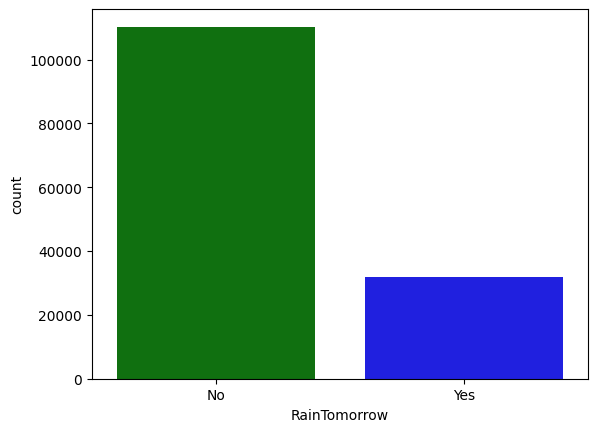

In [ ]:
# Đếm biểu đồ cột mục tiêu (Target)
cols =['green','blue']
sns.countplot(x=df['RainTomorrow'], palette= cols)

<Axes: >

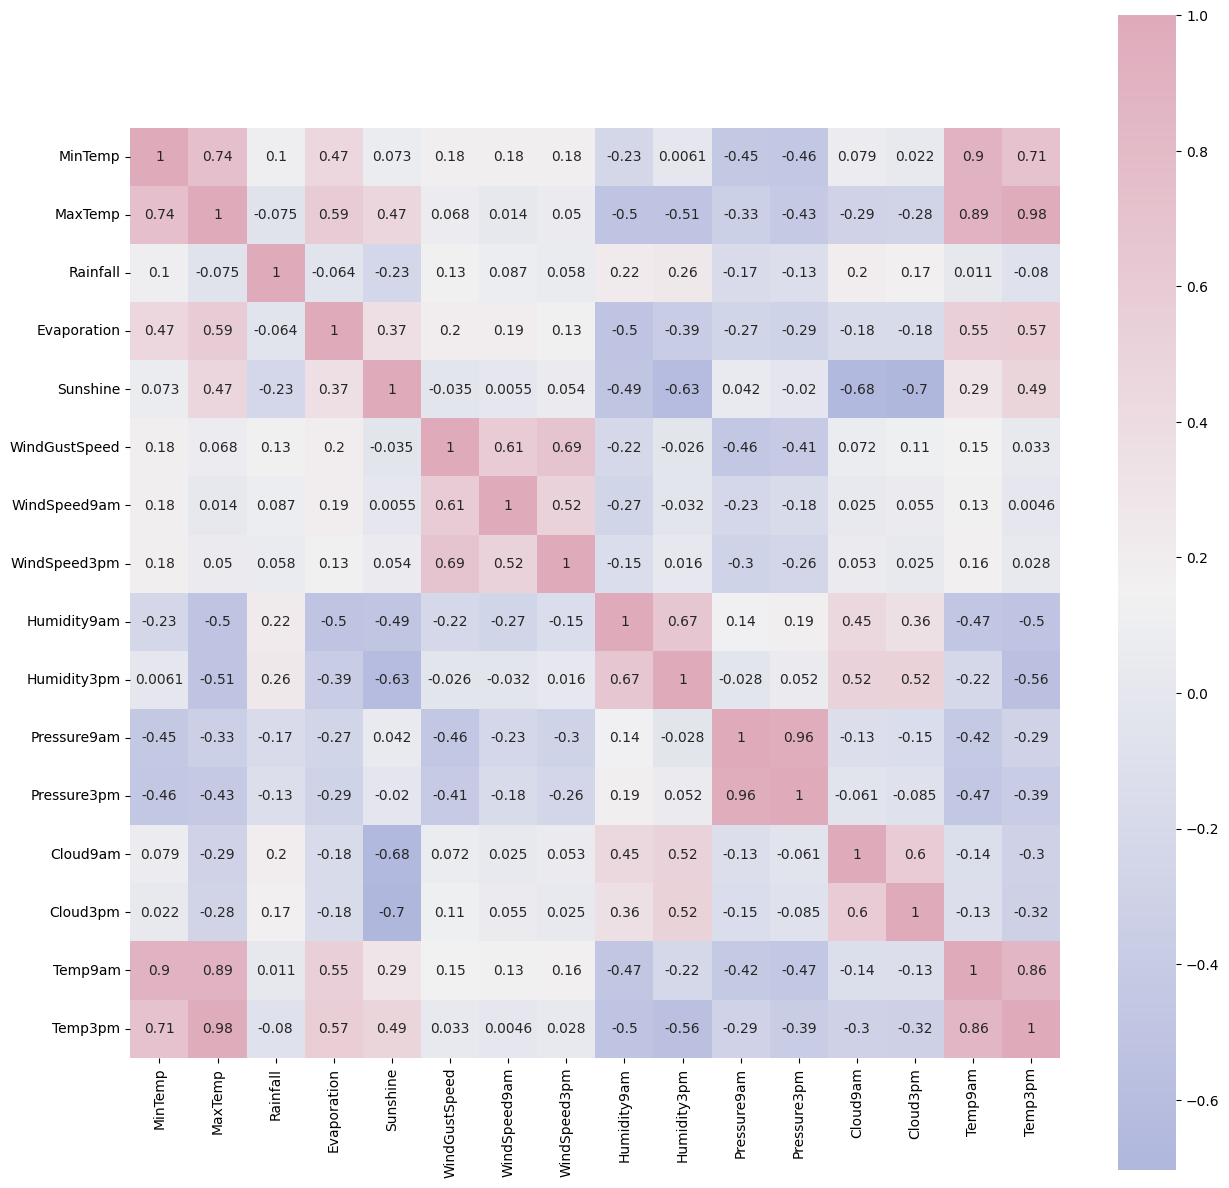

In [ ]:
# Biểu đồ tương quan giữa các thuộc tính
corrmat = df.corr()
cmap= sns.diverging_palette(260, -10, s=50, l=75,n =6, as_cmap=True)
plt.subplots(figsize=(15,15))
sns.heatmap(corrmat, cmap= cmap, annot= True, square =True)

In [ ]:
lengths= df['Date'].str.len()
lengths.value_counts()

10    145460
Name: Date, dtype: int64

In [ ]:
# Chuyển type int64 thành datetime của cột Date
df['Date']=pd.to_datetime(df['Date'])
# Tạo 1 cột cho năm (year)
df['year']= df.Date.dt.year

# Mã hóa dữ liệu ngày, tháng theo tham số tuần hoàn để hổ trợ thiết lập mô hình
def encode(data,col, max_val):
  df[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
  df[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
  return df
df['month'] = df.Date.dt.month
df= encode(df,'month',12)

df['day'] = df.Date.dt.day
df= encode(df, 'day',31)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

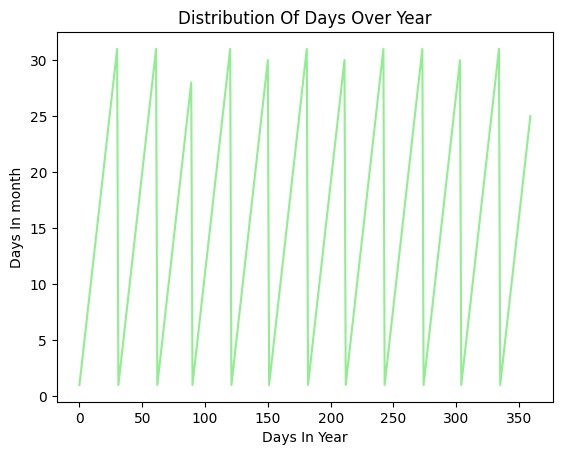

In [ ]:
#Biểu đồ phân phối của ngày trong khoảng 1 năm
# roughly a year's span section
section = df[:360]
tm = section["day"].plot(color="lightgreen")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")


Text(0.5, 0, 'Sine Encoded Months')

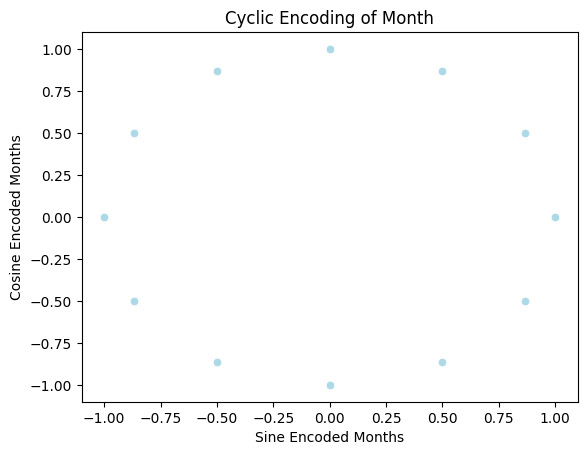

In [ ]:
# Biểu đồ phân phối chu kỳ của tháng
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=df, color="lightblue")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

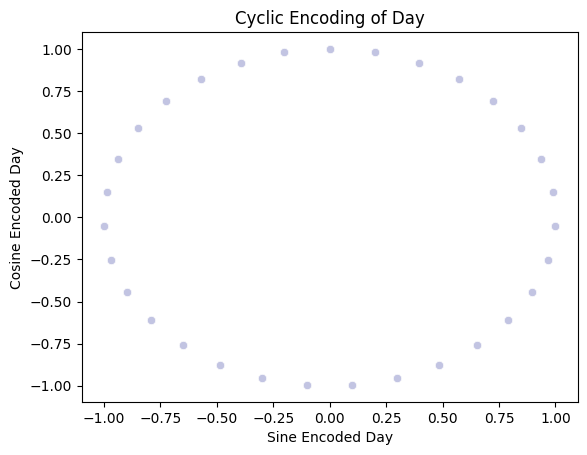

In [ ]:
# Biểu đồ phân phối chu kỳ của ngày
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=df, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [ ]:
s = (df.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [ ]:
for i in object_cols:
    print(i, df[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [ ]:
#Điền giá trị trống bằng mode của cột trong khoảng giá trị
for i in object_cols:
    df[i].fillna(df[i].mode()[0], inplace=True)

In [ ]:
t = (df.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [ ]:
for i in num_cols:
    print(i, df[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [ ]:
# Điền các giá trị thiếu bằng trung bình của cột giá trị
for i in num_cols:
    df[i].fillna(df[i].median(), inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

<Axes: xlabel='year', ylabel='Rainfall'>

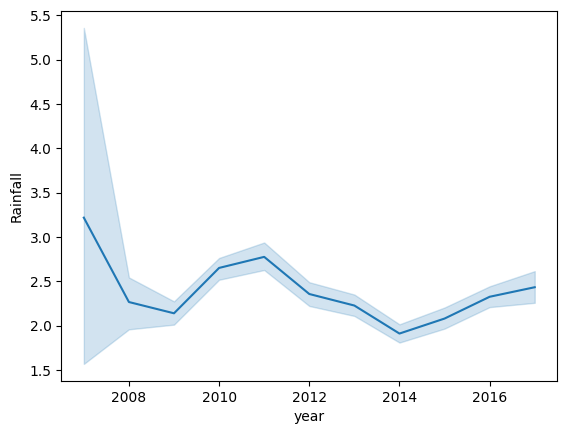

In [ ]:
# Biểu đồ hiển thị lượng mưa hằng năm
sns.lineplot(x=df['year'], y=df['Rainfall'])

<Figure size 500x500 with 0 Axes>

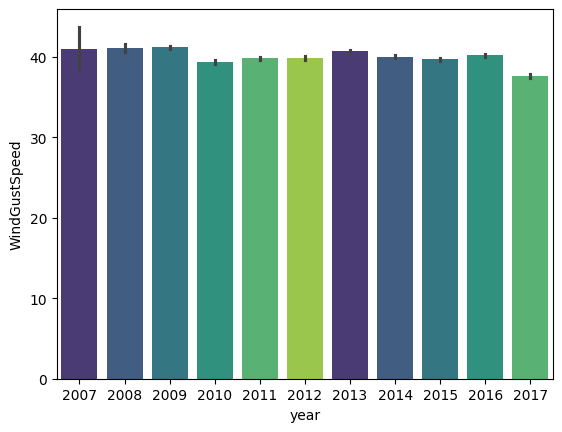

<Figure size 500x500 with 0 Axes>

In [ ]:
#Biểu đồ thể hiện tốc độ gió của từng năm
sns.barplot(x= df['year'], y= df['WindGustSpeed'], palette= sns.color_palette('viridis'))
plt.figure(figsize=(5,5))

Biểu đồ hiển thị nhiệt độ min/max trung bình mỗi năm

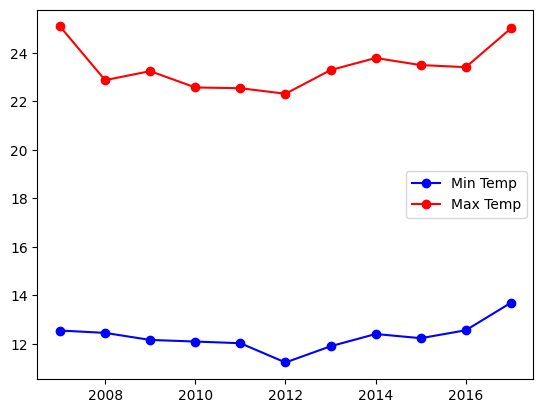

In [ ]:
average_min_temperature_per_year= df.groupby('year')['MinTemp'].mean()
average_max_temperature_per_year= df.groupby('year')['MaxTemp'].mean()
plt.plot(average_min_temperature_per_year.index, average_min_temperature_per_year.values, marker='o', linestyle='-', color='b', label='Min Temp')
plt.plot(average_max_temperature_per_year.index, average_max_temperature_per_year.values, marker='o', linestyle='-', color='r', label='Max Temp')
plt.legend()
plt.show()

# Tiền xử lí dữ liệu

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [ ]:
label_encoder = LabelEncoder()
for i in object_cols:
    df[i] = label_encoder.fit_transform(df[i])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int64         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int64         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int64         
 10  WindDir3pm     145460 non-null  int64         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [ ]:
#Hiển thị mô hình thống kê của các thuộc tính
#features = df.drop(['RainToday','RainTomorrow', 'Date','month_sin','month_cos','day_sin','day_cos'], axis=1)
features = df.drop(['RainTomorrow', 'Date','month_sin','month_cos','day_sin','day_cos'], axis=1)# dropping target and extra columns

target = df[['RainTomorrow']]

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,7.815677e-18,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.501830e-16,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,3.001220e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,7.815677e-18,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,-3.282584e-17,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-5.424080e-16,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,6.252542e-18,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,1.824961e-16,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,7.190423e-17,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,8.284618e-17,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


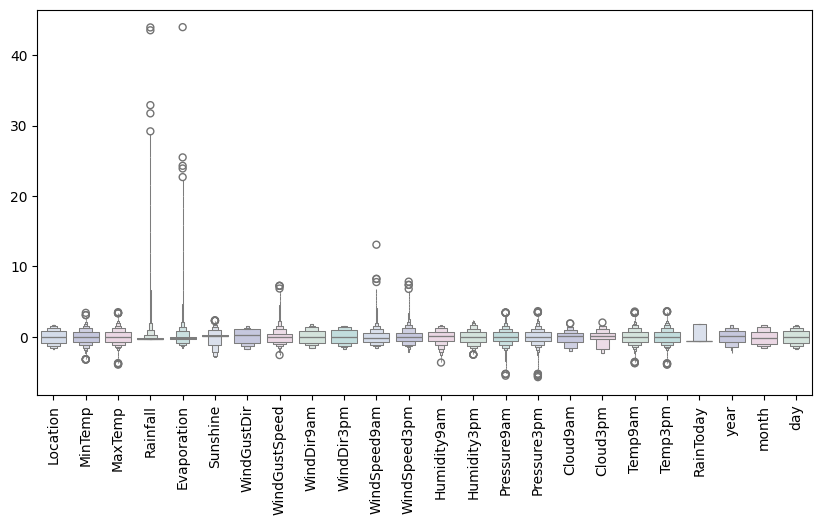

In [ ]:
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(10,5))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

=> Thông qua biểu đồ trên ta thấy được trong tập dữ liệu xuất hiện một số outlier vì vậy ta cần phải loại bỏ nó


#Tiến hành xóa các outlier

In [ ]:
#Thực hiện việc xóa outlier
#full data for
features[["RainTomorrow"]] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 25)

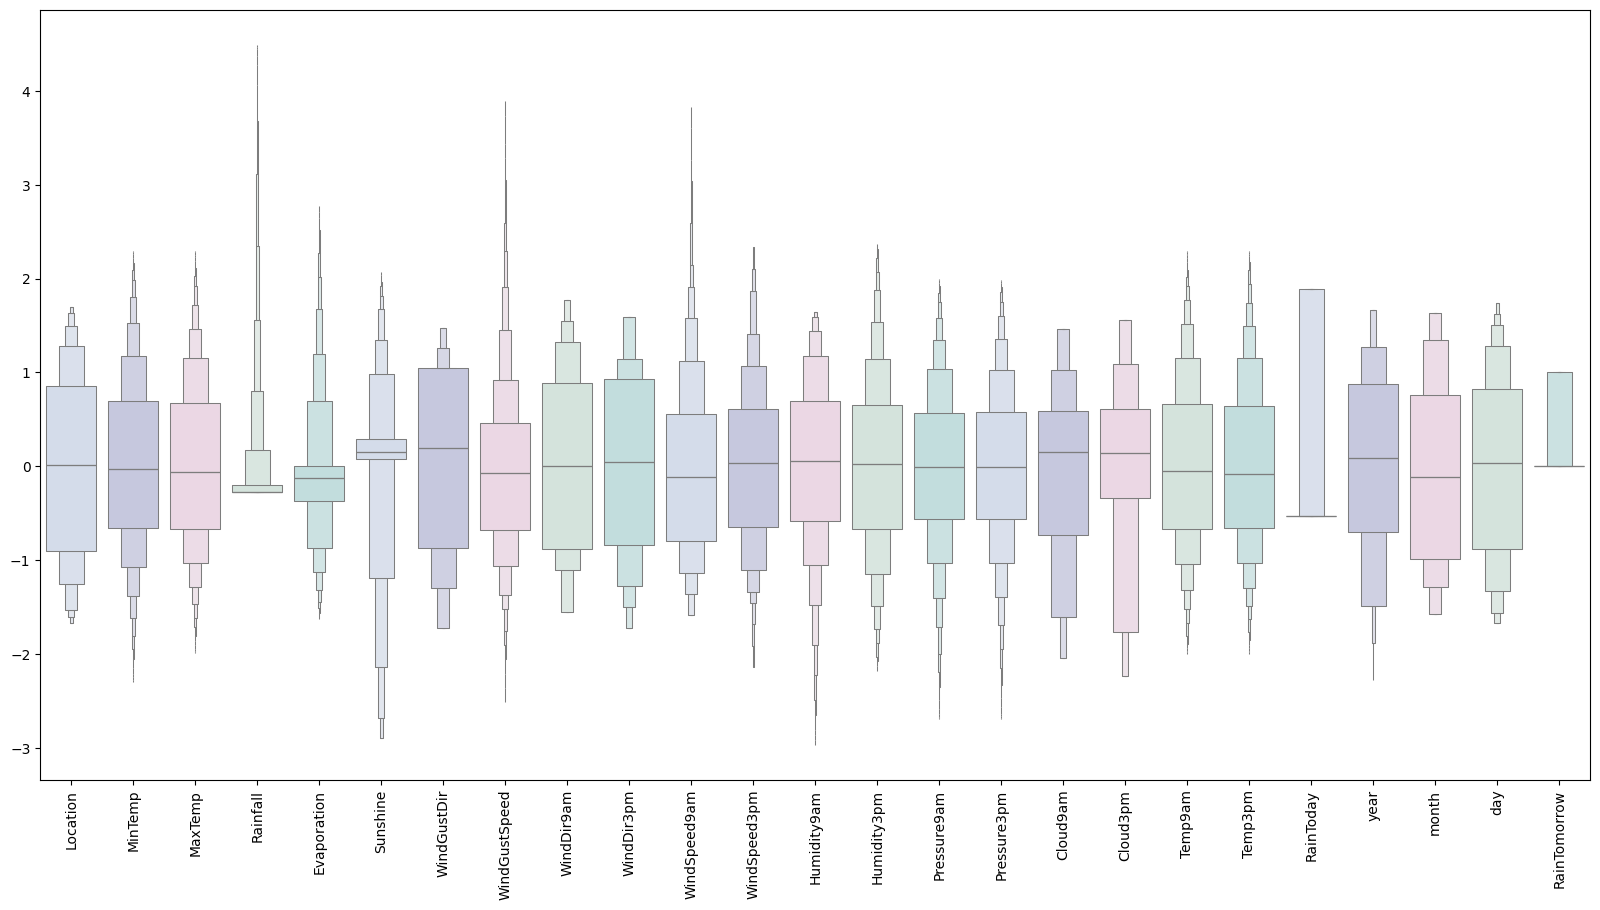

In [ ]:
# check lại để đảm bảo các outlier đã được xóa
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

#Xây dụng mô hình và đánh giá mô hình

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127536 entries, 0 to 145459
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       127536 non-null  float64
 1   MinTemp        127536 non-null  float64
 2   MaxTemp        127536 non-null  float64
 3   Rainfall       127536 non-null  float64
 4   Evaporation    127536 non-null  float64
 5   Sunshine       127536 non-null  float64
 6   WindGustDir    127536 non-null  float64
 7   WindGustSpeed  127536 non-null  float64
 8   WindDir9am     127536 non-null  float64
 9   WindDir3pm     127536 non-null  float64
 10  WindSpeed9am   127536 non-null  float64
 11  WindSpeed3pm   127536 non-null  float64
 12  Humidity9am    127536 non-null  float64
 13  Humidity3pm    127536 non-null  float64
 14  Pressure9am    127536 non-null  float64
 15  Pressure3pm    127536 non-null  float64
 16  Cloud9am       127536 non-null  float64
 17  Cloud3pm       127536 non-nul

In [ ]:
X = features.drop(['RainTomorrow'], axis = 1)
y=features['RainTomorrow']# Splitting df into X and y # Splitting df into X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,shuffle=True)
#Printing info on X and y
print(f'\nX shape: {X.shape}\n')
print(f'\n{len(X)} Samples \n')
print(f'\n{len(X.columns)} Attributes \n')
display(X.head(10))
print('\n')
print(f'\ny shape: {X.shape}\n')
print(f'\n{len(y)} Samples \n')
display(y.head(10))


X shape: (127536, 24)


127536 Samples 


24 Attributes 



,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month,day
0,-1.531666,0.189757,-0.044575,-0.203581,-0.119472,0.14871,1.045228,0.307739,1.328766,1.366458,...,-1.478015,-1.223012,1.464068,0.137693,-0.013506,0.019135,-0.529795,-1.879575,1.634076,-1.672844
1,-1.531666,-0.752786,0.265794,-0.275097,-0.119472,0.14871,1.258262,0.307739,-0.221338,1.586813,...,-1.047010,-1.117969,0.149133,0.137693,0.033011,0.384064,-0.529795,-1.879575,1.634076,-1.559140
2,-1.531666,0.111212,0.350440,-0.275097,-0.119472,0.14871,1.471296,0.460168,1.328766,1.586813,...,-1.492877,-0.982915,0.149133,-1.286294,0.622225,0.223495,-0.529795,-1.879575,1.634076,-1.445436
3,-1.531666,-0.470023,0.674917,-0.275097,-0.119472,0.14871,-0.872075,-1.216548,0.442992,-1.718521,...,-0.006653,-0.367666,0.149133,0.137693,0.172562,0.705202,-0.529795,-1.879575,1.634076,-1.331732
4,-1.531666,0.833828,1.281548,-0.155903,-0.119472,0.14871,1.045228,0.079096,-1.328556,-0.176032,...,-1.017286,-1.388078,1.025756,1.561680,0.126045,1.172312,-0.529795,-1.879575,1.634076,-1.218028
5,-1.531666,0.378265,0.914748,-0.251258,-0.119472,0.14871,1.258262,1.222312,1.328766,1.146102,...,-1.255082,-1.478115,0.149133,0.137693,0.560202,1.055535,-0.529795,-1.879575,1.634076,-1.104323
6,-1.531666,0.331138,0.251687,-0.275097,-0.119472,0.14871,1.045228,0.765025,1.107323,1.146102,...,-1.195633,-1.057945,-1.604113,0.137693,0.172562,0.427856,-0.529795,-1.879575,1.634076,-0.990619
7,-1.531666,-0.705659,0.491517,-0.275097,-0.119472,0.14871,1.045228,-0.378190,0.664436,1.146102,...,-0.630868,-0.772830,0.149133,0.137693,-0.106539,0.559231,-0.529795,-1.879575,1.634076,-0.876915
8,-1.531666,-0.391478,1.225117,-0.275097,-0.119472,0.14871,-0.446007,3.051456,0.442992,-0.176032,...,-1.299668,-1.748224,0.149133,0.137693,0.203573,1.245298,-0.529795,-1.879575,1.634076,-0.763211
9,-1.531666,0.142630,0.971179,-0.108226,-0.119472,0.14871,1.045228,-0.911691,0.221549,0.485035,...,-1.582051,-1.433097,0.149133,0.137693,0.482674,0.953355,1.887521,-1.879575,1.634076,-0.649507





y shape: (127536, 24)


127536 Samples 



0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    1
9    0
Name: RainTomorrow, dtype: int64

##Linear Regression

In [ ]:
#Tạo mô hình hồi quy
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_Linear = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_Linear)
mse = mean_squared_error(y_test, y_pred_Linear)
r2 = r2_score(y_test, y_pred_Linear)

print(f"LinearRegression Regression Mean Squared Error: {mse:.2f}")
print(f"LinearRegression Mean Absolute Error: {mae:.2f}")
print(f"LinearRegression R-squared: {r2:.2f}")

LinearRegression Regression Mean Squared Error: 0.12
LinearRegression Mean Absolute Error: 0.26
LinearRegression R-squared: 0.30


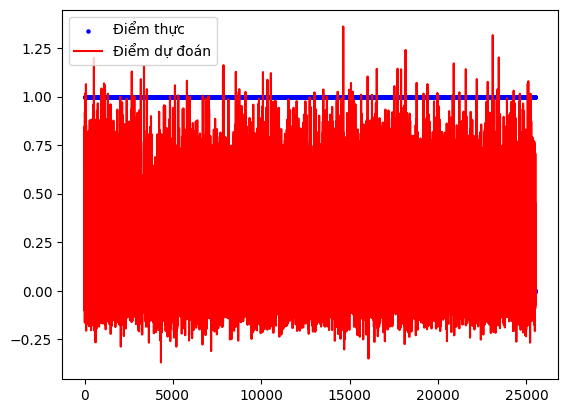

In [ ]:
#Trực quan hóa mô hình dự đoán
x_ax=range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="Điểm thực")
plt.plot(x_ax, y_pred_Linear, lw=1.5, color="red", label="Điểm dự đoán")
plt.legend()
plt.show()

##LASSO Regression

In [ ]:
# Tạo mô hình Lasso
lasso_model = Lasso(alpha=1.0)

# Fit the model to the training data
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
lasso_predictions = lasso_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, lasso_predictions)
mae = mean_absolute_error(y_test, lasso_predictions)
r2 = r2_score(y_test, lasso_predictions)

print(f"Lasso Regression Mean Squared Error: {mse:.2f}")
print(f"Lasso Regression Mean Absolute Error: {mae:.2f}")
print(f"Lasso Regression R-squared: {r2:.2f}")

Lasso Regression Mean Squared Error: 0.17
Lasso Regression Mean Absolute Error: 0.34
Lasso Regression R-squared: -0.00


In [ ]:
# Define the parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Lasso Regression model
lasso_model = Lasso()

# Initialize GridSearchCV
lasso_grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_lasso_params = lasso_grid_search.best_params_

# Initialize Lasso model with best hyperparameters
best_lasso_model = Lasso(alpha=best_lasso_params['alpha'])

In [ ]:
# Fit the Lasso model with the best hyperparameters
best_lasso_model.fit(X_train, y_train)

# Perform k-fold cross-validation
lasso_cv_scores = cross_val_score(best_lasso_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lasso_rmse_scores = np.sqrt(-lasso_cv_scores)

# Print the metrics
print("Lasso Regression Cross-Validation RMSE Scores:", lasso_rmse_scores)
print("Mean RMSE:", lasso_rmse_scores.mean())


lasso_predictions_k= best_lasso_model.predict(X_test)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, lasso_predictions_k)))
print("Test MAE:", mean_absolute_error(y_test, lasso_predictions_k))
print("Test R-squared:", r2_score(y_test, lasso_predictions_k))

Lasso Regression Cross-Validation RMSE Scores: [0.34144041 0.34412325 0.34254713 0.34462637 0.34435303]
Mean RMSE: 0.34341803951418426
Test RMSE: 0.3419611148317274
Test MAE: 0.2596487431892911
Test R-squared: 0.29909152004761197


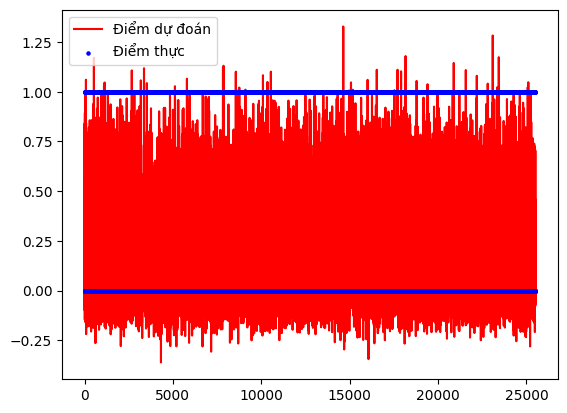

In [ ]:
#Trực quan mô hình dự đoán
x_ax=range(len(X_test))
plt.plot(x_ax, lasso_predictions_k, lw=1.5, color="red", label="Điểm dự đoán", zorder=1)
plt.scatter(x_ax, y_test, s=5, color="blue", label="Điểm thực", zorder=2)
plt.legend()
plt.show()

#Ridge Regression

In [ ]:
#Tạo mô hình ridge
ridge_model = Ridge(alpha=1.0)

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, ridge_predictions)
mae = mean_absolute_error(y_test, ridge_predictions)
r2 = r2_score(y_test, ridge_predictions)

print(f"Ridge Regression Mean Squared Error: {mse:.2f}")
print(f"Ridge Regression Mean Absolute Error: {mae:.2f}")
print(f"Ridge Regression R-squared: {r2:.2f}")

Ridge Regression Mean Squared Error: 0.12
Ridge Regression Mean Absolute Error: 0.26
Ridge Regression R-squared: 0.30


In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Ridge Regression model
ridge_model = Ridge()

# Initialize GridSearchCV
ridge_grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_ridge_params = ridge_grid_search.best_params_

# Initialize Ridge model with best hyperparameters
best_ridge_model = Ridge(alpha=best_ridge_params['alpha'])

In [ ]:
from sklearn.model_selection import cross_val_score
# Fit the Ridge model with the best hyperparameters
best_ridge_model.fit(X_train, y_train)

# Perform k-fold cross-validation
ridge_cv_scores = cross_val_score(best_ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
ridge_rmse_scores = np.sqrt(-ridge_cv_scores)

# Print the metrics
print("Ridge Regression Cross-Validation RMSE Scores:", ridge_rmse_scores)
print("Mean RMSE:", ridge_rmse_scores.mean())


ridge_predictions_k = best_ridge_model.predict(X_test)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, ridge_predictions_k)))
print("Test MAE:", mean_absolute_error(y_test, ridge_predictions_k))
print("Test R-squared:", r2_score(y_test, ridge_predictions_k))

Ridge Regression Cross-Validation RMSE Scores: [0.34116979 0.34367395 0.34241397 0.34441748 0.34433671]
Mean RMSE: 0.3432023783562378
Test RMSE: 0.3416920058048426
Test MAE: 0.25838232756200136
Test R-squared: 0.30019425701083047


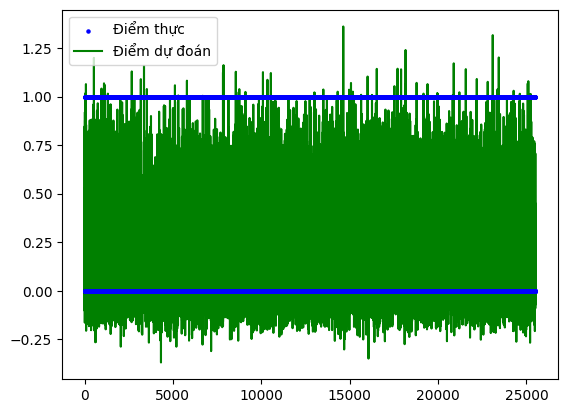

In [ ]:
x_ax=range(len(X_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="Điểm thực",zorder =2)
plt.plot(x_ax, ridge_predictions_k, lw=1.5, color="green", label="Điểm dự đoán", zorder =1)
plt.legend()
plt.show()

# Logistic Regression

In [ ]:
# Tạo mô hình hồi quy
model_Logistic = LogisticRegression(solver='liblinear')
model_Logistic.fit(X_train,y_train)
#Dự đoán
y_predict_Logistic = model_Logistic.predict(X_test)
r2 = r2_score(y_predict_Logistic,y_test)
x_ax=range(len(X_test))
mean_adjusted_r2 = np.mean(r2)
mean = mean_squared_error(y_predict_Logistic,y_test)
trainScore = math.sqrt(mean)
print('RMSE :',trainScore)
print(f'Mean Adjusted R-squared = {mean_adjusted_r2:.2f}')
print("Xác định độ chính xác",accuracy_score(y_test,y_predict_Logistic))

RMSE : 0.39440973656982914
Mean Adjusted R-squared = -0.26
Xác định độ chính xác 0.844440959698918


In [ ]:
# Define the parameter grid
param_grid = {'n_jobs': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Ridge Regression model
logis_model = LogisticRegression()

# Initialize GridSearchCV
logis_grid_search = GridSearchCV(logis_model, param_grid, cv=5, scoring='neg_mean_squared_error')
logis_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_logis_params = logis_grid_search.best_params_

# Initialize Ridge model with best hyperparameters
best_logis_model = LogisticRegression(n_jobs=best_logis_params['n_jobs'])

In [ ]:
from sklearn.model_selection import cross_val_score
# Fit the Ridge model with the best hyperparameters
best_logis_model.fit(X_train, y_train)

# Perform k-fold cross-validation
logis_cv_scores = cross_val_score(best_logis_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
logis_rmse_scores = np.sqrt(-logis_cv_scores)

# Print the metrics
print("Logistic Regression Cross-Validation RMSE Scores:", logis_rmse_scores)
print("Mean RMSE:", logis_rmse_scores.mean())


logis_predictions_k = best_logis_model.predict(X_test)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, logis_predictions_k)))
print("Test MAE:", mean_absolute_error(y_test, logis_predictions_k))
print("Test R-squared:", r2_score(y_test, logis_predictions_k))

Logistic Regression Cross-Validation RMSE Scores: [0.3930819  0.39476134 0.39587702 0.39508125 0.39835486]
Mean RMSE: 0.3954312740697641
Test RMSE: 0.39440973656982914
Test MAE: 0.155559040301082
Test R-squared: 0.06759816194332435


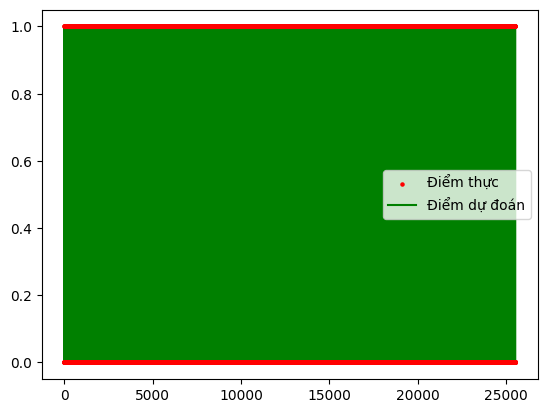

In [ ]:
#Trực quan hóa dự đoán
plt.scatter(x_ax, y_test, s=5, color="red", label="Điểm thực",zorder= 2)
plt.plot(x_ax, logis_predictions_k, lw=1.5, color="green", label="Điểm dự đoán",zorder =1)
plt.legend()
plt.show()

#Tiến hành dự đoán

In [ ]:

New_value=[[2,	13.4,	22.9,	0.6,	4.8,	8.4,	13,	44.0,	13,	14,	20.0,	24.0,	71.0,	22.0,	1007.7,	1007.1,	8.0,	5.0,	16.9,	21.8, 0, 2008,	12,	1]]
New_value= s_scaler.transform(New_value)

#Linear Regression

In [ ]:
value_predict = model.predict(New_value)

threshold = 0.5
binary_ex_predict = (value_predict >= threshold).astype(int)
print("Predictions (continuous):", value_predict)
print("Predictions (binary):", binary_ex_predict)

Predictions (continuous): [-0.03074358]
Predictions (binary): [0]


##LASSO Regression

In [ ]:
LA_predict = best_lasso_model.predict(New_value)
print('Prediction: ',value_predict)

Prediction:  [-0.03074358]


##Ridge Regression

In [ ]:
Rd_predict = best_ridge_model.predict(New_value)
print('Prediction: ',value_predict)

Prediction:  [-0.03074358]


##Logistic Regression

In [ ]:
LG_predict = best_logis_model.predict(New_value)
print('Prediction: ',LG_predict)

Prediction:  [0]
